# J1リーグにおけるスタジアム観客動員数を予測するモデル

#### データ概要

学習用：2006 ~ 2017年のJ1リーグ各試合の観客動員数、チーム名、開催スタジアム、天候、出場メンバー、試合結果等の情報
評価用：2018～2019年のJ1リーグの試合の情報

* 学習用試合データ（train.csv）
    * データ数 ： 3,672
    * データ説明 ： 対戦カードとその対戦の観客数等を記したデータです。

* 評価用試合データ（test.csv）
    * データ数 ： 612
    * データ説明 ： 対戦カードを記したデータです。

* 会場情報（venue_information.csv）
    * データ数 ： 120
    * データ説明 ： 試合会場のスタジアムに関する詳細データです。
    * 注意事項  ：収容人数は取得した情報先や収容人数の変化などによって揺らぎが存在する可能性がございます。このためcapacity(収容人数)がattendance(観客動員数)を上回ることがございます。

* 試合詳細データ（match_reports.csv）
    * データ数 ： 4,284
    * データ説明 ： 各試合の詳細データです。

* 休日情報（holidays_in_japan.csv）
    * データ数 ： 245
    * データ説明 ： 祝日データです


#### 評価方法

予測する変数は、スタジアムの入場者数です。（ある日の予測をする時は、その日に確定している情報のみ使用してください）
応募ファイルの形式はcsv（カンマ区切り）のヘッダーなしファイルです。
評価用データの1列目にある値をインデックスとし、2列目に予測値を記述します。
精度評価は、評価関数「RMSE（Root Mean Squared Error 平均二乗誤差）」を使用します。
評価値は0以上の値をとり、精度が高いほど小さな値となります。
コンペ最終日までの評価（暫定評価）は評価用データセットの一部で評価し、コンペ終了後の評価（最終評価）は評価用データセットの残りの部分で評価します。

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv('/Users/okuran/Desktop/ML/DTRA/train.csv')
test_df = pd.read_csv('/Users/okuran/Desktop/ML/DTRA/test.csv')
venue_information_df = pd.read_csv('/Users/okuran/Desktop/ML/DTRA/venue_information.csv')
match_reports_df = pd.read_csv('/Users/okuran/Desktop/ML/DTRA/match_reports.csv')
holidays_df = pd.read_csv('/Users/okuran/Desktop/ML/DTRA/holidays_in_japan.csv')

print("Train Data:")
print(train_df.head())
print("\nTest Data:")
print(test_df.head())
print("\nVenue Information:")
print(venue_information_df.head())
print("\nMatch Reports:")
print(match_reports_df.head())
print("\nHolidays:")
print(holidays_df.head())

Train Data:
     id  match_date kick_off_time section round home_team away_team  \
0  9190  2006-03-04         16:04     第1節   第1日       G大阪        浦和   
1  9191  2006-03-05         13:00     第1節   第2日        甲府        清水   
2  9192  2006-03-05         13:35     第1節   第2日      FC東京        大分   
3  9193  2006-03-05         14:04     第1節   第2日        磐田        福岡   
4  9194  2006-03-05         14:04     第1節   第2日       名古屋       C大阪   

              venue weather  temperature  humidity  \
0           万博記念競技場       晴       8.3000        40   
1  山梨県小瀬スポーツ公園陸上競技場       晴      12.9000        28   
2          味の素スタジアム       晴      12.1000        35   
3        静岡スタジアムエコパ       晴      11.6000        42   
4       名古屋市瑞穂陸上競技場       晴      13.1000        32   

                                 broadcasters  attendance  
0                           NHK総合/J SPORTS(録)       20916  
1                   山梨放送/テレビ静岡(録)/J SPORTS(録)       14277  
2                   BS-i/MXテレビ(録)/J SPORTS(録)       2253

In [203]:
print("\nTrain Data Description:\n", train_df.describe())
print("\nTest Data Description:\n", test_df.describe())
print("\nVenue Information Description:\n", venue_information_df.describe())
print("\nMatch Reports Description:\n", match_reports_df.describe())
print("\nHolidays in Japan Description:\n", holidays_df.describe())


Train Data Description:
               id  temperature  humidity  attendance
count  3672.0000    3672.0000 3672.0000   3672.0000
mean  13956.4167      21.0727   60.6588  18037.9308
std    3024.6737       6.0745   18.5940   9376.2499
min    9190.0000       0.8000   12.0000      0.0000
25%   11489.0000      16.6000   47.0000  11622.2500
50%   13768.5000      21.9000   62.0000  15402.0000
75%   16181.2500      26.1000   76.0000  21241.2500
max   19380.0000      34.2000   99.0000  62632.0000

Test Data Description:
               id  temperature  humidity
count   612.0000     612.0000  612.0000
mean  21269.0000      21.7771   56.0882
std     382.1699       5.9167   19.6928
min   20745.0000       3.6000   15.0000
25%   20897.7500      17.7750   41.0000
50%   21269.0000      22.3000   55.0000
75%   21640.2500      26.3000   72.0000
max   21793.0000      33.6000   97.0000

Venue Information Description:
         capacity
count   120.0000
mean  23241.1417
std   12865.1723
min    5046.0000
25%

In [204]:
print("Train Data Missing Values:\n", train_df.isnull().sum())
print("\nTest Data Missing Values:\n", test_df.isnull().sum())
print("\nVenue Information Missing Values:\n", venue_information_df.isnull().sum())
print("\nMatch Reports Missing Values:\n", match_reports_df.isnull().sum())
print("\nHolidays in Japan Missing Values:\n", holidays_df.isnull().sum())


Train Data Missing Values:
 id               0
match_date       0
kick_off_time    0
section          0
round            0
home_team        0
away_team        0
venue            0
weather          0
temperature      0
humidity         0
broadcasters     0
attendance       0
dtype: int64

Test Data Missing Values:
 id               0
match_date       0
kick_off_time    0
section          0
round            0
home_team        0
away_team        0
venue            0
weather          0
temperature      0
humidity         0
broadcasters     0
dtype: int64

Venue Information Missing Values:
 venue       0
capacity    0
address     0
dtype: int64

Match Reports Missing Values:
 id                    0
home_team_player11    0
home_team_player10    0
home_team_player9     0
home_team_player8     0
home_team_player7     0
home_team_player6     0
home_team_player5     0
home_team_player4     0
home_team_player3     0
home_team_player2     0
home_team_player1     0
home_team_score       0
away_tea

## Preprocess the Data

In [205]:
train_df = train_df.merge(venue_information_df, on='venue', how='left')
test_df = test_df.merge(venue_information_df, on='venue', how='left')

train_df = train_df.merge(match_reports_df, on='id', how='left')
test_df = test_df.merge(match_reports_df, on='id', how='left')

print("Train Data after Merging:\n", train_df.head())
print("\nTest Data after Merging:\n", test_df.head())

Train Data after Merging:
      id  match_date kick_off_time section round home_team away_team  \
0  9190  2006-03-04         16:04     第1節   第1日       G大阪        浦和   
1  9191  2006-03-05         13:00     第1節   第2日        甲府        清水   
2  9192  2006-03-05         13:35     第1節   第2日      FC東京        大分   
3  9193  2006-03-05         14:04     第1節   第2日        磐田        福岡   
4  9194  2006-03-05         14:04     第1節   第2日       名古屋       C大阪   

              venue weather  temperature  ...  away_team_player2  \
0           万博記念競技場       晴       8.3000  ...          2 坪井慶介 DF   
1  山梨県小瀬スポーツ公園陸上競技場       晴      12.9000  ...         25 市川大祐 DF   
2          味の素スタジアム       晴      12.1000  ...          2 三木隆司 DF   
3        静岡スタジアムエコパ       晴      11.6000  ...         22 中村北斗 DF   
4       名古屋市瑞穂陸上競技場       晴      13.1000  ...     2 ブルーノクアドロス DF   

  away_team_player3  away_team_player4  away_team_player5 away_team_player6  \
0    4 田中マルクス闘莉王 DF         20 堀之内聖 DF          6 山田暢久 MF 

In [206]:
train_df['match_date'] = pd.to_datetime(train_df['match_date'])
test_df['match_date'] = pd.to_datetime(test_df['match_date'])

train_df['year'] = train_df['match_date'].dt.year
train_df['month'] = train_df['match_date'].dt.month
train_df['day'] = train_df['match_date'].dt.day
train_df['day_of_week'] = train_df['match_date'].dt.dayofweek

test_df['year'] = test_df['match_date'].dt.year
test_df['month'] = test_df['match_date'].dt.month
test_df['day'] = test_df['match_date'].dt.day
test_df['day_of_week'] = test_df['match_date'].dt.dayofweek

print("Train Data with Date Features:\n", train_df.head())
print("\nTest Data with Date Features:\n", test_df.head())


Train Data with Date Features:
      id match_date kick_off_time section round home_team away_team  \
0  9190 2006-03-04         16:04     第1節   第1日       G大阪        浦和   
1  9191 2006-03-05         13:00     第1節   第2日        甲府        清水   
2  9192 2006-03-05         13:35     第1節   第2日      FC東京        大分   
3  9193 2006-03-05         14:04     第1節   第2日        磐田        福岡   
4  9194 2006-03-05         14:04     第1節   第2日       名古屋       C大阪   

              venue weather  temperature  ...  away_team_player6  \
0           万博記念競技場       晴       8.3000  ...         17 長谷部誠 MF   
1  山梨県小瀬スポーツ公園陸上競技場       晴      12.9000  ...         13 兵働昭弘 MF   
2          味の素スタジアム       晴      12.1000  ...        11 トゥーリオ MF   
3        静岡スタジアムエコパ       晴      11.6000  ...          7 宮崎光平 MF   
4       名古屋市瑞穂陸上競技場       晴      13.1000  ...         23 下村東美 MF   

  away_team_player7  away_team_player8  away_team_player9 away_team_player10  \
0        13 鈴木啓太 MF     8 三都主アレサンドロ MF         18 小野伸二 MF 

In [207]:
train_df['kick_off_hour'] = pd.to_datetime(train_df['kick_off_time'], format='%H:%M').dt.hour
test_df['kick_off_hour'] = pd.to_datetime(test_df['kick_off_time'], format='%H:%M').dt.hour

In [208]:
holiday_dict = pd.to_datetime(holidays_df['holiday_date']).to_list()

train_df['is_holiday'] = train_df['match_date'].isin(holiday_dict).astype(int)
test_df['is_holiday'] = test_df['match_date'].isin(holiday_dict).astype(int)

train_df['is_weekend'] = train_df['day_of_week'].isin([5, 6]).astype(int)
test_df['is_weekend'] = test_df['day_of_week'].isin([5, 6]).astype(int)

In [209]:
train_df['is_night_game'] = train_df['kick_off_hour'].apply(lambda x: 1 if x >= 18 else 0)
test_df['is_night_game'] = test_df['kick_off_hour'].apply(lambda x: 1 if x >= 18 else 0)

In [210]:
train_df['home_team'] = train_df['home_team'].str.replace('Ｃ', 'C')
train_df['away_team'] = train_df['away_team'].str.replace('Ｃ', 'C')
test_df['home_team'] = test_df['home_team'].str.replace('Ｃ', 'C')
test_df['away_team'] = test_df['away_team'].str.replace('Ｃ', 'C')
train_df['home_team'] = train_df['home_team'].str.replace('Ｇ', 'G')
train_df['away_team'] = train_df['away_team'].str.replace('Ｇ', 'G')
test_df['home_team'] = test_df['home_team'].str.replace('Ｇ', 'G')
test_df['away_team'] = test_df['away_team'].str.replace('Ｇ', 'G')
train_df['home_team'] = train_df['home_team'].str.replace('Ｆ', 'F')
train_df['away_team'] = train_df['away_team'].str.replace('Ｆ', 'F')
test_df['home_team'] = test_df['home_team'].str.replace('Ｆ', 'F')
test_df['away_team'] = test_df['away_team'].str.replace('Ｆ', 'F')

print(train_df['home_team'].unique())
print(train_df['away_team'].unique())


['G大阪' '甲府' 'FC東京' '磐田' '名古屋' '大宮' '川崎F' '広島' '横浜FM' '浦和' '千葉' '新潟' '清水'
 '鹿島' '京都' '福岡' '大分' 'C大阪' '柏' '横浜FC' '神戸' '札幌' '東京V' '山形' '湘南' '仙台' '鳥栖'
 '徳島' '松本']
['浦和' '清水' '大分' '福岡' 'C大阪' '千葉' '新潟' '鹿島' '京都' '磐田' '甲府' 'FC東京' '名古屋'
 '横浜FM' '川崎F' '大宮' '広島' 'G大阪' '神戸' '横浜FC' '柏' '札幌' '東京V' '山形' '仙台' '湘南'
 '鳥栖' '徳島' '松本']


In [211]:
pop_teams = ['川崎F','新潟', '横浜FM', '神戸', '鹿島', '広島', 'G大阪', '名古屋', '浦和', 'FC東京']

# 人气比赛
train_df['pop_match'] = train_df.apply(lambda row: 1 if row['home_team'] in pop_teams and row['away_team'] in pop_teams else 0, axis=1)
test_df['pop_match'] = test_df.apply(lambda row: 1 if row['home_team'] in pop_teams and row['away_team'] in pop_teams else 0, axis=1)

# 人气队伍在主场
train_df['pop_home'] = train_df.apply(lambda row: 1 if row['home_team'] in pop_teams else 0, axis=1)
test_df['pop_home'] = test_df.apply(lambda row: 1 if row['home_team'] in pop_teams else 0, axis=1)

# 德比
derby_teams = [('G大阪', 'C大阪'), ('FC東京', '東京V'), ('横浜FM', '横浜FC'),('浦和', '大宮'), ('清水', '磐田'),('FC東京', '川崎F')]
train_df['derby_match'] = train_df.apply(lambda row: 1 if (row['home_team'], row['away_team']) in derby_teams or (row['away_team'], row['home_team']) in derby_teams else 0, axis=1)
test_df['derby_match'] = test_df.apply(lambda row: 1 if (row['home_team'], row['away_team']) in derby_teams or (row['away_team'], row['home_team']) in derby_teams else 0, axis=1)


In [212]:
def simplify_weather(weather):
    if '屋内' in weather:
        return '屋内'
    elif '雪' in weather:
        return '雨'
    elif '雨' in weather:
        return '雨'
    elif '曇' in weather:
        return '曇'
    elif '晴' in weather:
        return '晴'
    elif '霧' in weather:
        return '曇'
    else:
        return weather

train_df['weather_simple'] = train_df['weather'].apply(simplify_weather)
test_df['weather_simple'] = test_df['weather'].apply(simplify_weather)
print(train_df['weather_simple'].value_counts())

weather_simple
晴     1828
曇     1175
雨      568
屋内     101
Name: count, dtype: int64


In [213]:
train_df['broadcast_num'] = train_df['broadcasters'].apply(lambda x: len(x.split('/')))
test_df['broadcast_num'] = test_df['broadcasters'].apply(lambda x: len(x.split('/')))

# 合并 broadcast_num 列中 5, 6, 8 的情况为 5
train_df['broadcast_num'] = train_df['broadcast_num'].replace([6, 8], 5)
test_df['broadcast_num'] = test_df['broadcast_num'].replace([6, 8], 5)

print(train_df['broadcast_num'].value_counts())


broadcast_num
2    1744
3    1198
4     343
1     323
5      64
Name: count, dtype: int64


In [214]:
train_df['section_encoded'] = train_df['section'].str.extract('(\d+)').astype(int)
test_df['section_encoded'] = test_df['section'].str.extract('(\d+)').astype(int)

train_df.drop(columns=['section'], inplace=True)
test_df.drop(columns=['section'], inplace=True)

In [215]:
train_df['round_encoded'] = train_df['round'].str.extract('(\d+)').astype(int)
test_df['round_encoded'] = test_df['round'].str.extract('(\d+)').astype(int)

train_df.drop(columns=['round'], inplace=True)
test_df.drop(columns=['round'], inplace=True)

# 确定round_encoded列的缺失值
print(train_df['round_encoded'].isnull().sum().sum())
print(test_df['round_encoded'].isnull().sum().sum())


0
0


In [216]:
print(train_df.columns)

Index(['id', 'match_date', 'kick_off_time', 'home_team', 'away_team', 'venue',
       'weather', 'temperature', 'humidity', 'broadcasters', 'attendance',
       'capacity', 'address', 'home_team_player11', 'home_team_player10',
       'home_team_player9', 'home_team_player8', 'home_team_player7',
       'home_team_player6', 'home_team_player5', 'home_team_player4',
       'home_team_player3', 'home_team_player2', 'home_team_player1',
       'home_team_score', 'away_team_score', 'away_team_player1',
       'away_team_player2', 'away_team_player3', 'away_team_player4',
       'away_team_player5', 'away_team_player6', 'away_team_player7',
       'away_team_player8', 'away_team_player9', 'away_team_player10',
       'away_team_player11', 'year', 'month', 'day', 'day_of_week',
       'kick_off_hour', 'is_holiday', 'is_weekend', 'is_night_game',
       'pop_match', 'pop_home', 'derby_match', 'weather_simple',
       'broadcast_num', 'section_encoded', 'round_encoded'],
      dtype='object')


In [217]:
train_df.to_csv("train_df.csv", index=None)
test_df.to_csv("test_df.csv", index=None)

## Data Visualization

In [218]:
%pip install japanize-matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [219]:
train_df.describe()

,id,match_date,temperature,humidity,attendance,capacity,home_team_score,away_team_score,year,month,...,kick_off_hour,is_holiday,is_weekend,is_night_game,pop_match,pop_home,derby_match,broadcast_num,section_encoded,round_encoded
count,3672.0000,3672,3672.0000,3672.0000,3672.0000,3672.0000,3672.0000,3672.0000,3672.0000,3672.0000,...,3672.0000,3672.0000,3672.0000,3672.0000,3672.0000,3672.0000,3672.0000,3672.0000,3672.0000,3672.0000
mean,13956.4167,2012-01-14 13:52:09.411764736,21.0727,60.6588,18037.9308,31974.3932,1.4711,1.2590,2011.5000,6.9551,...,16.5498,0.0776,0.8510,0.4504,0.2653,0.5278,0.0212,2.4774,16.0833,1.2130
min,9190.0000,2006-03-04 00:00:00,0.8000,12.0000,0.0000,12584.0000,0.0000,0.0000,2006.0000,2.0000,...,12.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000
25%,11489.0000,2009-02-12 06:00:00,16.6000,47.0000,11622.2500,19526.0000,1.0000,0.0000,2008.7500,5.0000,...,14.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,8.0000,1.0000
50%,13768.5000,2012-01-21 00:00:00,21.9000,62.0000,15402.0000,26232.0000,1.0000,1.0000,2011.5000,7.0000,...,16.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,2.0000,15.0000,1.0000
75%,16181.2500,2014-12-30 06:00:00,26.1000,76.0000,21241.2500,41684.0000,2.0000,2.0000,2014.2500,9.0000,...,19.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,3.0000,24.0000,1.0000
max,19380.0000,2017-12-02 00:00:00,34.2000,99.0000,62632.0000,71624.0000,8.0000,7.0000,2017.0000,12.0000,...,20.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,5.0000,34.0000,4.0000
std,3024.6737,NaN,6.0745,18.5940,9376.2499,15974.9291,1.2620,1.1405,3.4525,2.6322,...,2.2061,0.2676,0.3561,0.4976,0.4415,0.4993,0.1442,0.8468,9.7092,0.4353


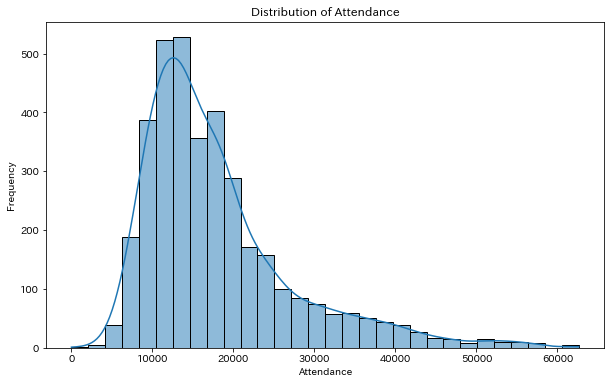

In [220]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train_df['attendance'], bins=30, kde=True)
plt.title('Distribution of Attendance')
plt.xlabel('Attendance')
plt.ylabel('Frequency')
plt.show()

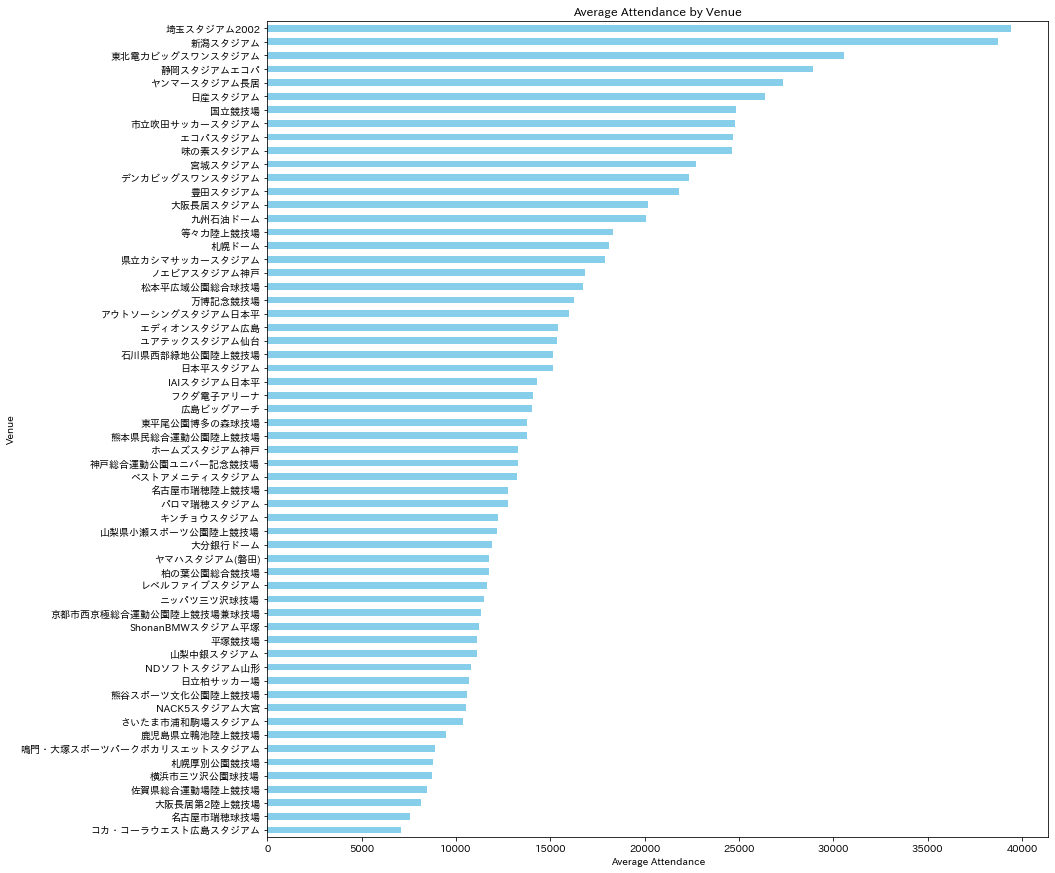

In [221]:
venue_attendance_mean = train_df.groupby('venue')['attendance'].mean().sort_values()

plt.figure(figsize=(14, 15))

venue_attendance_mean.plot(kind='barh', color='skyblue')

plt.title('Average Attendance by Venue')
plt.xlabel('Average Attendance')
plt.ylabel('Venue')

plt.show()

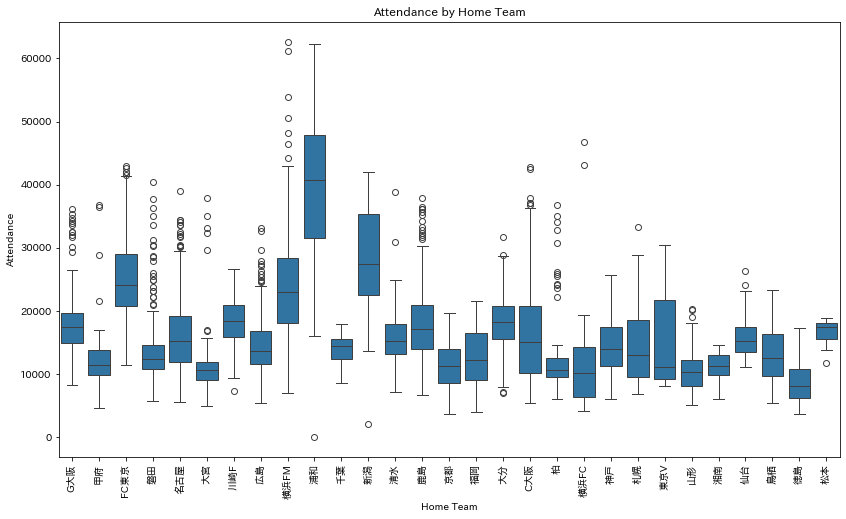

In [222]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='home_team', y='attendance', data=train_df)
plt.title('Attendance by Home Team')
plt.xticks(rotation=90)
plt.xlabel('Home Team')
plt.ylabel('Attendance')
plt.show()

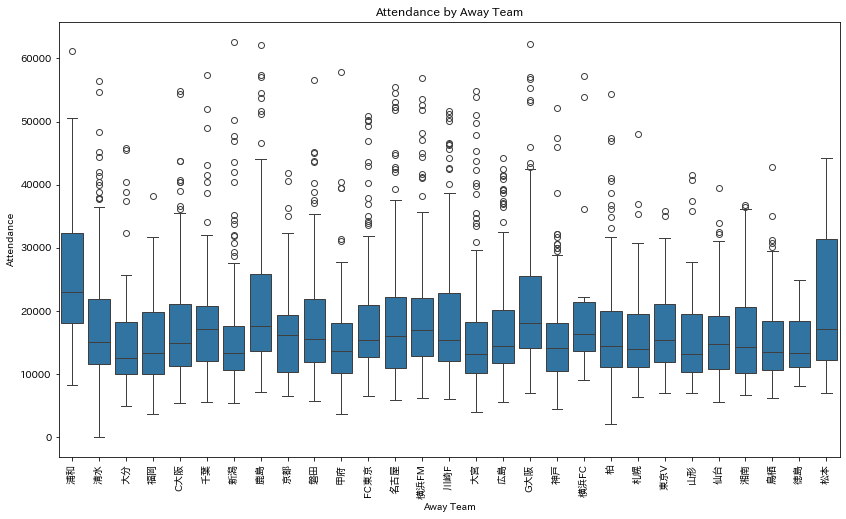

In [223]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='away_team', y='attendance', data=train_df)
plt.title('Attendance by Away Team')
plt.xticks(rotation=90)
plt.xlabel('Away Team')
plt.ylabel('Attendance')
plt.show()

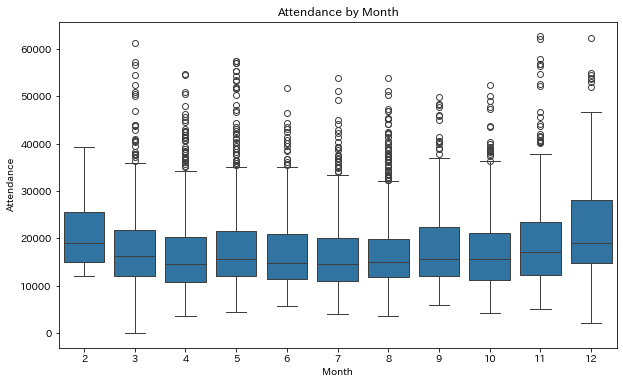

In [224]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='attendance', data=train_df)
plt.title('Attendance by Month')
plt.xlabel('Month')
plt.ylabel('Attendance')
plt.show()

<ipython-input-225-3ae6277e21ee>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='attendance', data=attendance_means, palette='viridis')


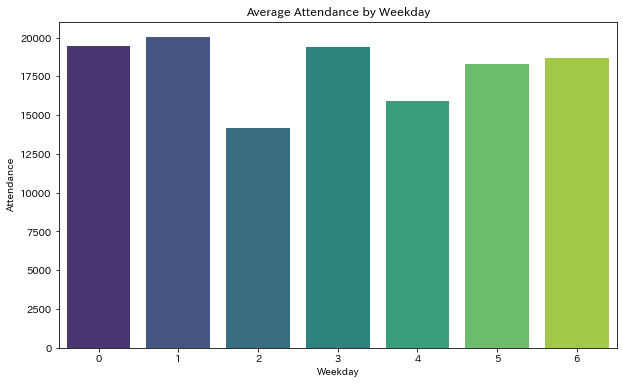

In [225]:
attendance_means = train_df.groupby('day_of_week')['attendance'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='attendance', data=attendance_means, palette='viridis')
plt.title('Average Attendance by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Attendance')
plt.show()

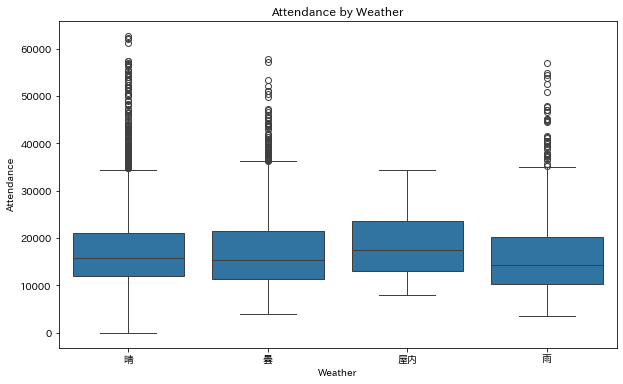

In [226]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_simple', y='attendance', data=train_df)
plt.title('Attendance by Weather')
plt.xlabel('Weather')
plt.ylabel('Attendance')
plt.show()

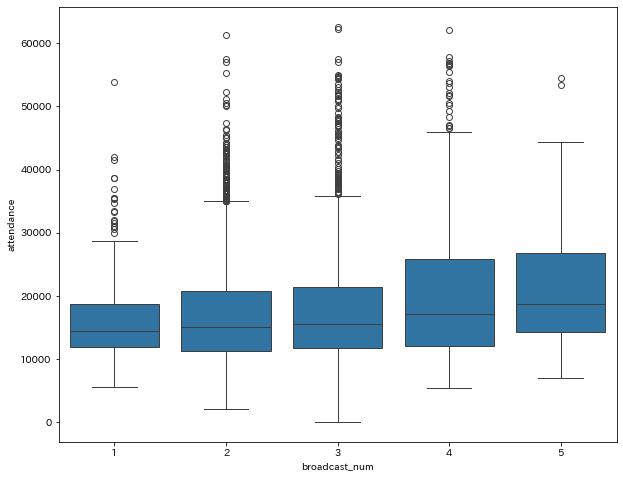

In [227]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='broadcast_num', y='attendance', data=train_df)
plt.show()

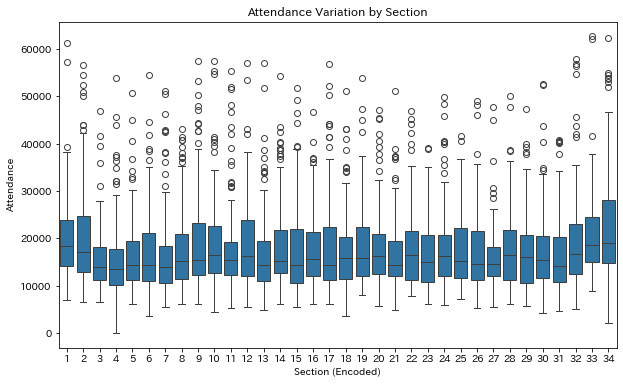

In [228]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='section_encoded', y='attendance', data=train_df)

plt.title('Attendance Variation by Section')
plt.xlabel('Section (Encoded)')
plt.ylabel('Attendance')

plt.show()

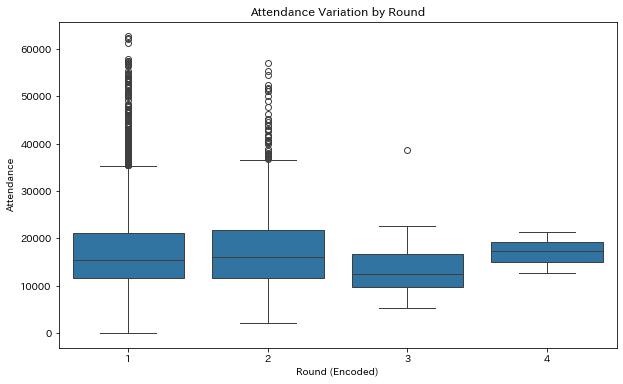

In [229]:
round_attendance_mean = train_df.groupby('round_encoded')['attendance'].mean().reset_index()

plt.figure(figsize=(10, 6))

sns.boxplot(x='round_encoded', y='attendance', data=train_df)

plt.title('Attendance Variation by Round')
plt.xlabel('Round (Encoded)')
plt.ylabel('Attendance')

plt.show()

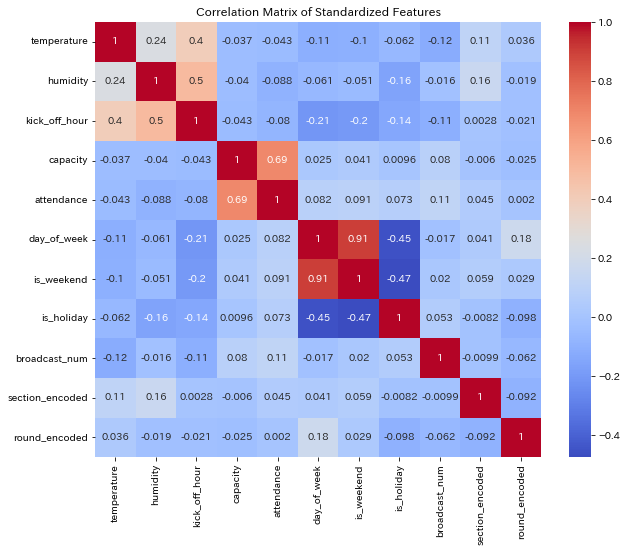

In [230]:
from scipy.stats import zscore

numeric_features = ['temperature', 'humidity', 'kick_off_hour', 'capacity', 'attendance', 'day_of_week', 'is_weekend','is_holiday', 'broadcast_num', 'section_encoded', 'round_encoded']
train_df_standardized = train_df[numeric_features].apply(zscore)

correlation_matrix_standardized = train_df_standardized.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_standardized, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Standardized Features')
plt.show()